This notebook compares performance between the binary and multi-class classifiers trained on BCN20000.
It loads saved artifacts, displays side-by-side metrics for Accuracy, Recall, and AUROC, and writes comparison plots into ../artifacts/plots/.

In [5]:
import sys, os, json, csv
sys.path.append(os.path.abspath(".."))

import matplotlib.pyplot as plt
import numpy as np

Utilities to load metrics JSON and optional logs, and to ensure output directories.

In [6]:
def ensure_dir(path):
    os.makedirs(path, exist_ok=True)
    return path

def load_json(path):
    with open(path, "r") as f:
        return json.load(f)

def load_csv_rows(path):
    rows = []
    with open(path, "r") as f:
        r = csv.reader(f)
        header = next(r, None)
        for row in r:
            rows.append(row)
    return rows

Plotting helpers for bar charts and quick image display.

In [7]:
def plot_bar_comparison(metric_names, bin_values, mc_values, title, out_path=None):
    idx = np.arange(len(metric_names))
    w = 0.35
    fig = plt.figure(figsize=(7,4))
    plt.bar(idx - w/2, bin_values, width=w, label="Binary")
    plt.bar(idx + w/2, mc_values, width=w, label="Multiclass")
    plt.xticks(idx, metric_names)
    plt.ylim(0, 1)
    for i, v in enumerate(bin_values):
        plt.text(i - w/2, v + 0.02, f"{v:.3f}", ha="center")
    for i, v in enumerate(mc_values):
        plt.text(i + w/2, v + 0.02, f"{v:.3f}", ha="center")
    plt.title(title)
    plt.ylabel("Score")
    plt.legend()
    if out_path:
        ensure_dir(os.path.dirname(out_path))
        fig.savefig(out_path, bbox_inches="tight")
    plt.show()
    plt.close(fig)

def show_image(path, title):
    if not os.path.isfile(path):
        return False
    img = plt.imread(path)
    fig = plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(title)
    plt.show()
    plt.close(fig)
    return True

Comparison orchestration that reads saved metrics from the binary and multiclass notebooks and renders the figures inline and to disk.
Paths assume:
- ../artifacts/binary_metrics.json
- ../artifacts/multiclass_metrics.json
- ../artifacts/plots/binary_resnet18_results_*.png
- ../artifacts/plots/multiclass_resnet18_tta15e_*.png

In [8]:
def run_comparison(
    binary_metrics_json="../artifacts/binary_metrics.json",
    multiclass_metrics_json="../artifacts/multiclass_metrics.json",
    out_dir="../artifacts/plots",
    bin_tag="binary_resnet18_results",
    mc_tag="multiclass_resnet18_tta15e"
):
    bin_metrics = load_json(binary_metrics_json)
    mc_metrics = load_json(multiclass_metrics_json)
    bin_vals = [
        float(bin_metrics.get("val_accuracy", bin_metrics.get("accuracy", 0.0))),
        float(bin_metrics.get("val_recall",   bin_metrics.get("recall",   0.0))),
        float(bin_metrics.get("val_auroc",    bin_metrics.get("auroc",    0.0))),
    ]
    mc_vals = [
        float(mc_metrics.get("accuracy", 0.0)),
        float(mc_metrics.get("recall_macro", 0.0)),
        float(mc_metrics.get("auroc_macro_ovr", 0.0)),
    ]
    names = ["Accuracy", "Recall", "AUROC"]
    out_path = os.path.join(out_dir, "compare_binary_vs_multiclass_bars.png")
    plot_bar_comparison(names, bin_vals, mc_vals, "Binary vs Multiclass: Core Metrics", out_path=out_path)
    bin_roc = os.path.join(out_dir, f"{bin_tag}_roc.png")
    mc_roc  = os.path.join(out_dir, f"{mc_tag}_roc_ovr.png")
    show_image(bin_roc, "Binary ROC")
    show_image(mc_roc,  "Multiclass ROC (OVR)")
    bin_cm = os.path.join(out_dir, f"{bin_tag}_confusion.png")
    mc_cm  = os.path.join(out_dir, f"{mc_tag}_confusion.png")
    show_image(bin_cm, "Binary Confusion")
    show_image(mc_cm,  "Multiclass Confusion")
    return {
        "binary": bin_metrics,
        "multiclass": mc_metrics,
        "bar_plot": out_path,
        "binary_roc": bin_roc,
        "multiclass_roc": mc_roc,
        "binary_confusion": bin_cm,
        "multiclass_confusion": mc_cm
    }

Run the comparison. The returned dictionary contains loaded metrics and the key plot paths that were saved.

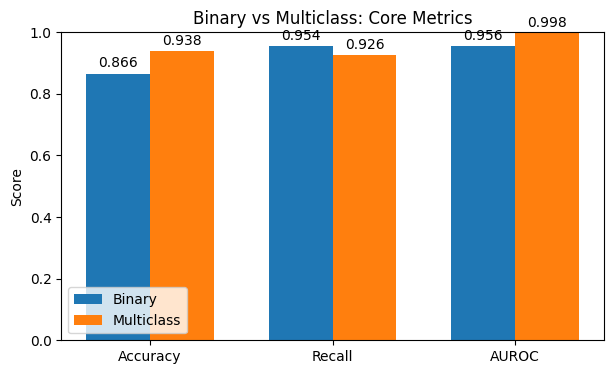

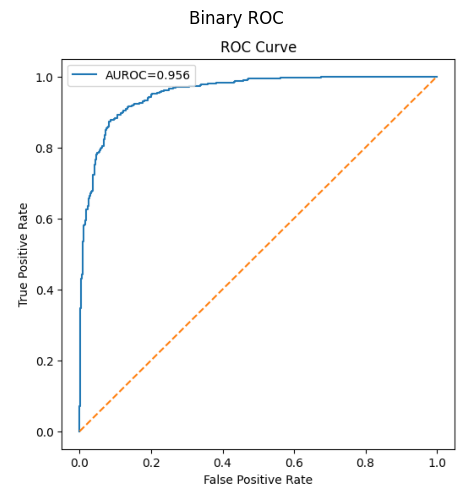

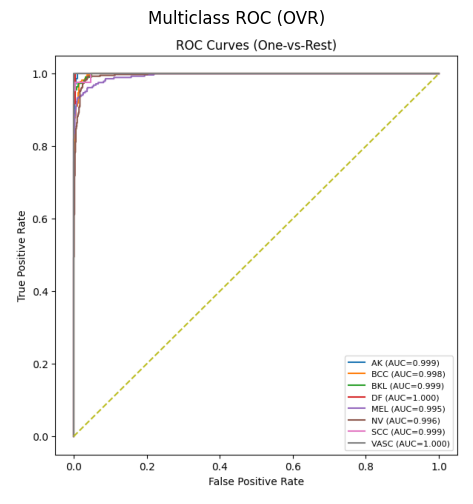

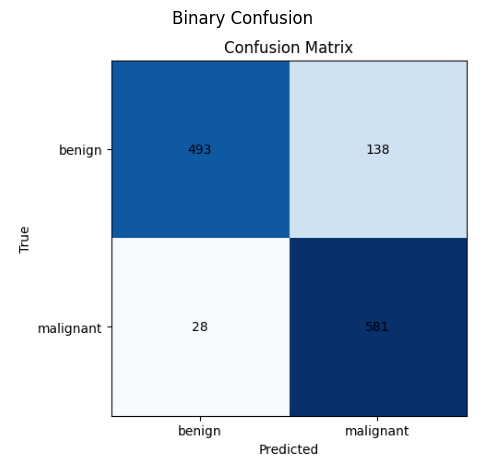

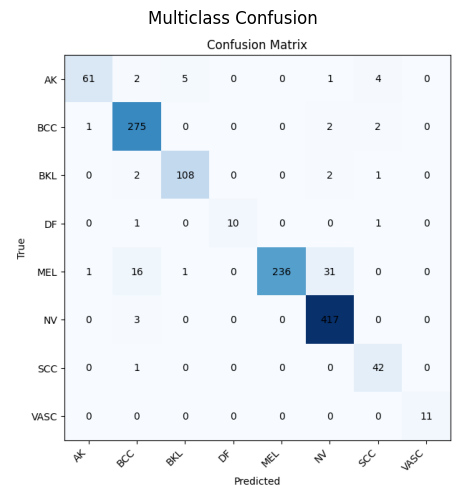

{'binary': {'accuracy': 0.8661290322580645,
  'recall': 0.9540229885057471,
  'auroc': 0.9561776729927994,
  'epochs': 15,
  'batch_size': 64,
  'lr': 0.001},
 'multiclass': {'label_names': ['AK',
   'BCC',
   'BKL',
   'DF',
   'MEL',
   'NV',
   'SCC',
   'VASC'],
  'accuracy': 0.9377526273241714,
  'recall_macro': 0.9255645431954983,
  'auroc_macro_ovr': 0.9980264074028743,
  'epochs': 15,
  'batch_size': 64,
  'lr': 0.001},
 'bar_plot': '../artifacts/plots/compare_binary_vs_multiclass_bars.png',
 'binary_roc': '../artifacts/plots/binary_resnet18_results_roc.png',
 'multiclass_roc': '../artifacts/plots/multiclass_resnet18_tta15e_roc_ovr.png',
 'binary_confusion': '../artifacts/plots/binary_resnet18_results_confusion.png',
 'multiclass_confusion': '../artifacts/plots/multiclass_resnet18_tta15e_confusion.png'}

In [9]:
results = run_comparison()
results